## Imports

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys


# my scripts
sys.path.append('../scripts/python/')
from tax_assignment_downstream import create_count_plot_all_samples, standardize_taxopath, tax_composition_per_sample, tax_composition_per_sample_percentages, create_venn, count_tax_assigned_otus

## Variables

In [2]:
project = 'Suthaus_2022'
marker = 'Full18S'
sim = 'sim_90'
denoise_method = 'RAD'
raw_data = os.path.join('..', 'raw_data')
results = os.path.join('..', 'results')

# Phylogenetic placement

## Variables

In [ ]:
tax_assign_dir = os.path.join(results, 'phyl_placement', 'tax_assignment', project, marker, denoise_method, sim, 'vampyrella')
tax_assign_files = [file for file in os.listdir(tax_assign_dir) if file.endswith('_per_query.tsv')]
save_dir = os.path.join(results, 'phyl_placement', 'figures', project, marker, denoise_method, sim)

In [ ]:
# Initialize an empty DataFrame to store all data
tax_assign = pd.DataFrame()

for file in tax_assign_files:
    # Read each file into a DataFrame
    data = os.path.join(tax_assign_dir, file)
    df = pd.read_csv(data, sep='\t')
    # Extract sample name
    sample_name = file.split('_')[0]
    # Add the sample name as a new column
    df['sample'] = sample_name
    # Concatenate this DataFrame with the main DataFrame
    tax_assign = pd.concat([tax_assign, df], ignore_index = True)

In [ ]:
tax_assign.head(1)

## Dataframe adjustments

In [ ]:
# Continue with the 'name', 'LWR', 'taxopath', 'sample' columns
tax_assign = tax_assign[['name', 'LWR', 'taxopath', 'sample']]

In [ ]:
# Group by otu_id and select the row with the longest taxopath for each group
tax_assign = tax_assign.groupby('name').apply(lambda x: x[x['taxopath'].str.len() == x['taxopath'].str.len().max()])

# Reset the index of the DataFrame
tax_assign.reset_index(drop=True, inplace=True)

In [ ]:
# Group by otu_id and select the row with the highest LWR for each group
tax_assign = tax_assign.groupby('name').apply(lambda x: x[x['LWR'] == x['LWR'].max()])

# Reset the index of the DataFrame
tax_assign.reset_index(drop=True, inplace=True)

In [ ]:
# standardize the taxopath column by ensuring that each entry has the same level of taxonomic detail.
# In our case, we want each taxopath to have four levels:
# order, family, genus, and species.
# If any level is missing, it should be filled with 'unassigned'.

# Apply the function to the 'taxopath' column
tax_assign['taxopath'] = tax_assign['taxopath'].apply(standardize_taxopath)

In [ ]:
# split the taxopath into individual columns for each taxonomic level is correct and efficient.
# The code will create new columns named:
# 'order', 'family', 'genus', and 'species',
# each containing the respective taxonomic level extracted from the taxopath.

tax_levels = ['order', 'family', 'genus', 'species']

for i in range(len(tax_levels)):
    tax_assign[f'{tax_levels[i]}'] = tax_assign['taxopath'].apply(lambda a: a.split(';')[i])

In [ ]:
# remove the 'taxopath' column
tax_assign = tax_assign.drop('taxopath', axis=1)

In [ ]:
# Rename 'Vampyrellida_clade_PurpleVamp' to 'PurpleVamp' in the 'family' column
tax_assign['family'] = tax_assign['family'].replace('Vampyrellida_clade_PurpleVamp', 'PurpleVamp')

In [ ]:
# Rename columns
tax_assign.rename(columns={'name': 'otu', 'LWR': 'confidence'}, inplace=True)

In [ ]:
tax_assign.head(3)

In [ ]:
# Save 'tax_assign' DataFrame as csv
tax_assign.to_csv(os.path.join(tax_assign_dir, 'tax_assign.csv'), index=False)

## Plotting number of OTUs at different taxonomic level for all samples except mock community

In [ ]:
tax_level = 'genus'

# Note:
# If the x-axis labels are overlapped set: xlabels_rotation=30, xlabels_ha = 'right'
# Otherwise xlabels_rotation=0, xlabels_ha = 'center'

create_count_plot_all_samples(dataframe = tax_assign, tax_level = tax_level, save_dir = save_dir, xlabels_rotation=30, xlabels_ha = 'right')

## Creating taxonomic composition plots

Compare the taxonomic composition between individual samples and create a stacked bar plot.

In [ ]:
tax_assign.head(3)

### Dataframe adjustments

In [ ]:
taxonomic_level = 'genus'

# Filter out the mock sample
tax_assign_filtered = tax_assign[tax_assign['sample'] != 'Mock']

# Aggregate data to get counts per taxonomic group per sample
group_counts = tax_assign_filtered.groupby(['sample', taxonomic_level]).size().reset_index(name='counts')

# Prepare data for plotting
pivot_table = group_counts.pivot(index='sample', columns=taxonomic_level, values='counts').fillna(0)

### Plotting

In [ ]:
save_dir = os.path.join(results, 'phyl_placement', 'figures', project, marker, denoise_method, sim)
rename_dict = {
    'NH1': 'Neuenhähnen 1',
    'NH4': 'Neuenhähnen 4',
    'Sim17': 'Simmelried 17',
    'Sim22': 'Simmelried 22',
    'Th16': 'Thielenbruch 16',
    'Th38': 'Thielenbruch 38',
    'X17007': 'Deep Sea X17007'}

In [ ]:
# Taxonomic composition plot per sample with absolute numbers (Number of OTUs)
tax_composition_per_sample(pivot_table = pivot_table, 
                           taxonomic_level = taxonomic_level,
                           rename_dict = rename_dict,
                           save_dir = save_dir, 
                           xlabels_rotation = 30, 
                           xlabels_ha = 'right', 
                           xlabels_fontsize = 9)

In [ ]:
# Taxonomic composition per sample as percentages
tax_composition_per_sample_percentages(pivot_table = pivot_table, 
                                       taxonomic_level = taxonomic_level,
                                       rename_dict = rename_dict,
                                       save_dir = save_dir, 
                                       xlabels_rotation = 30, 
                                       xlabels_ha = 'right', 
                                       xlabels_fontsize = 9)

## Plotting LWR ratio distribution

# VSEARCH Taxonomic Assignment

## Variables

In [ ]:
tax_assign_dir = os.path.join(results, 'tax_assignment_vsearch', project, marker, sim, denoise_method, 'blast')
tax_assign_files = [file for file in os.listdir(tax_assign_dir) if file.startswith('blast6_') and file.endswith('.tab')]
save_dir = os.path.join(results, 'tax_assignment_vsearch', 'figures', project, marker, denoise_method, sim)

## Creating dataframe

In [ ]:
tax_assign = pd.DataFrame()

for file in tax_assign_files:
    sample_name = file.split('_')[1]
    path = os.path.join(tax_assign_dir, file)
    df = pd.read_csv(path, sep='\t', header=None)
    df['sample'] = sample_name
    tax_assign = pd.concat([tax_assign, df], ignore_index = True)

tax_assign.head(3)

## Dataframe adjustments

In [ ]:
# Dropping unnecessery columns
tax_assign = tax_assign[[0, 1, 2, 'sample']]

In [ ]:
# Rename columns
tax_assign.rename(columns={0: 'otu', 1: 'taxopath', 2: 'confidence'}, inplace=True)

In [ ]:
# Keep only vampyrellids
tax_assign = tax_assign[tax_assign['taxopath'].str.contains('o:Vampyrellida')]

In [ ]:
# split the taxopath into individual columns for each taxonomic level is correct and efficient.
# The code will create new columns named:
# 'order', 'family', 'genus', and 'species',
# each containing the respective taxonomic level extracted from the taxopath.

tax_levels = ['order', 'family', 'genus', 'species']

for i in range(len(tax_levels)):
    tax_assign[f'{tax_levels[i]}'] = tax_assign['taxopath'].apply(lambda a: a.split(',')[i+4].split(':')[1])

In [ ]:
# remove the 'taxopath' column
tax_assign = tax_assign.drop('taxopath', axis=1)

In [ ]:
# filter out all sequences associated with the 'mock' sample
tax_assign = tax_assign[tax_assign['sample'] != 'Mock']

In [ ]:
# Rename 'Vampyrellida_clade_PurpleVamp' to 'PurpleVamp' in the 'family' column
tax_assign['family'] = tax_assign['family'].replace('Vampyrellida_clade_PurpleVamp', 'PurpleVamp')

In [ ]:
tax_assign.head(3)

In [ ]:
# Save 'tax_assign' DataFrame as csv
tax_assign.to_csv(os.path.join(tax_assign_dir, 'tax_assign.csv'), index=False)

## Plotting number of OTUs at different taxonomic level for all samples except mock community

In [ ]:
tax_level = 'family'

# Note:
# If the x-axis labels are overlapped set: xlabels_rotation=30, xlabels_ha = 'right'
# Otherwise xlabels_rotation=0, xlabels_ha = 'center'

create_count_plot_all_samples(dataframe = tax_assign, tax_level = tax_level, save_dir = save_dir, xlabels_rotation=0, xlabels_ha = 'center')

## Creating taxonomic composition plots

Compare the taxonomic composition between individual samples and create a stacked bar plot.

### Dataframe adjustments

In [ ]:
taxonomic_level = 'family'

# Aggregate data to get counts per taxonomic group per sample
group_counts = tax_assign.groupby(['sample', taxonomic_level]).size().reset_index(name='counts')

# Prepare data for plotting
pivot_table = group_counts.pivot(index='sample', columns=taxonomic_level, values='counts').fillna(0)

In [ ]:
pivot_table

### Plotting

In [ ]:
save_dir = os.path.join(results, 'tax_assignment_vsearch', 'figures', project, marker, denoise_method, sim)
rename_dict = {
    'NH1': 'Neuenhähnen 1',
    'NH4': 'Neuenhähnen 4',
    'Sim17': 'Simmelried 17',
    'Sim22': 'Simmelried 22',
    'Th16': 'Thielenbruch 16',
    'Th38': 'Thielenbruch 38',
    'X17007': 'Deep Sea X17007'}

In [ ]:
# Taxonomic composition plot per sample with absolute numbers (Number of OTUs)
tax_composition_per_sample(pivot_table = pivot_table, 
                           taxonomic_level = taxonomic_level,
                           rename_dict = rename_dict,
                           save_dir = save_dir, 
                           xlabels_rotation = 30, 
                           xlabels_ha = 'right', 
                           xlabels_fontsize = 9)

In [ ]:
# Taxonomic composition per sample as percentages
tax_composition_per_sample_percentages(pivot_table = pivot_table, 
                                       taxonomic_level = taxonomic_level,
                                       rename_dict = rename_dict,
                                       save_dir = save_dir, 
                                       xlabels_rotation = 30, 
                                       xlabels_ha = 'right', 
                                       xlabels_fontsize = 9)

# Phylogenetic placement (*GAPPA*) vs. Blast (*VSEARCH*)

## Variables

In [3]:
phyl_placement_dir = os.path.join(results, 'phyl_placement', 'tax_assignment', project, marker, denoise_method, sim, 'vampyrella')
blast_results_dir = os.path.join(results, 'tax_assignment_vsearch', project, marker, sim, denoise_method, 'blast')

## Read input tables

In [4]:
# Read the csv tables from phylogenetic placement and blast results into a single DataFrame
tax_assign_gappa = pd.read_csv(os.path.join(phyl_placement_dir, 'tax_assign.csv'))
tax_assign_vsearch = pd.read_csv(os.path.join(blast_results_dir, 'tax_assign.csv'))

# Add approach column
tax_assign_gappa['approach'] = 'gappa'
tax_assign_vsearch['approach'] = 'vsearch'

# Concatenate tax_assign_gappa and tax_assign_vsearch into a tax_assign DataFrame
tax_assign = pd.concat([tax_assign_gappa, tax_assign_vsearch], ignore_index=True)

## Venn Diagrams

Creating Venn diagrams to compare the number of unique and shared Operational Taxonomic Units (OTUs) between two approaches:
- phylogenetic placement in *'GAPPA'*
- Blast in *'VSEARCH'*

In [ ]:
# Prepare data for plotting Venn diagrams
# Extract sets of tuples for each taxonomic level ('order', 'family', 'genus', 'species') and approach (gappa, vsearch)
# NOTE: I excluded all the 'unassigned' sequences (!= 'unassigned') since these do not contribute to the analysis of shared taxonomy

tax_levels = ['order', 'family', 'genus', 'species']
plot_data = {}

for tax_level in tax_levels:
    plot_data[f'otus_{tax_level}_gappa'] = set(
        tax_assign[
            (tax_assign['approach'] == 'gappa') &
            (tax_assign[tax_level] != 'unassigned')
        ][['otu', tax_level]].apply(tuple, axis=1))
    
    plot_data[f'otus_{tax_level}_vsearch'] = set(
        tax_assign[
            (tax_assign['approach'] == 'vsearch') &
            (tax_assign[tax_level] != 'unassigned')
                ][['otu', tax_level]].apply(tuple, axis=1))

In [ ]:
save_dir = os.path.join(results, 'main_figures')
project = 'suthaus_2022'

create_venn(save_dir = save_dir,
            plot_data = plot_data,
            project = project)

In [ ]:
# Display the OTUs that are unique to each method

# Unique OTUs in gappa not in vsearch
unique_otus_gappa = plot_data['otus_order_gappa'] - plot_data['otus_order_vsearch']
print("Unique OTUs in Gappa:")
print(unique_otus_gappa)

# Unique OTUs in vsearch not in gappa
unique_otus_vsearch = plot_data['otus_order_vsearch'] - plot_data['otus_order_gappa']
print("\nUnique OTUs in VSEARCH:")
print(unique_otus_vsearch)

In [ ]:
# Check the unique OTUs in the DataFrame
# GAPPA
tax_assign[tax_assign['otu'] == list(unique_otus_gappa)[0][0]]

## Assigned vs. Unassigned OTUs

Create a count plot comparing the number of assigned and unassigned OTUs across different taxonomic levels and between the two approaches (Gappa and VSEARCH)

In [5]:
# Transform the DataFrame to count the number of assigned and unassigned OTUs at each taxonomic level for each approach.

# Step 1: Create a new DataFrame indicating 'assigned' or 'unassigned' for each taxonomic level
for level in ['order', 'family', 'genus', 'species']:
    tax_assign[f'{level}_status'] = tax_assign[level].apply(lambda x: 'unassigned' if x == 'unassigned' else 'assigned')

# Step 2: Melt the DataFrame to create a long-form DataFrame
melted_df = pd.melt(tax_assign, id_vars=['otu', 'approach'], value_vars=['order_status', 'family_status', 'genus_status', 'species_status'],
                    var_name='taxonomic_level', value_name='status')

# Step 3: Adjust the 'taxonomic_level' values to have just the level names
melted_df['taxonomic_level'] = melted_df['taxonomic_level'].str.replace('_status', '')

# Step 4: Filter to keep only assigned OTUs
melted_df = melted_df[melted_df['status'] == 'assigned']

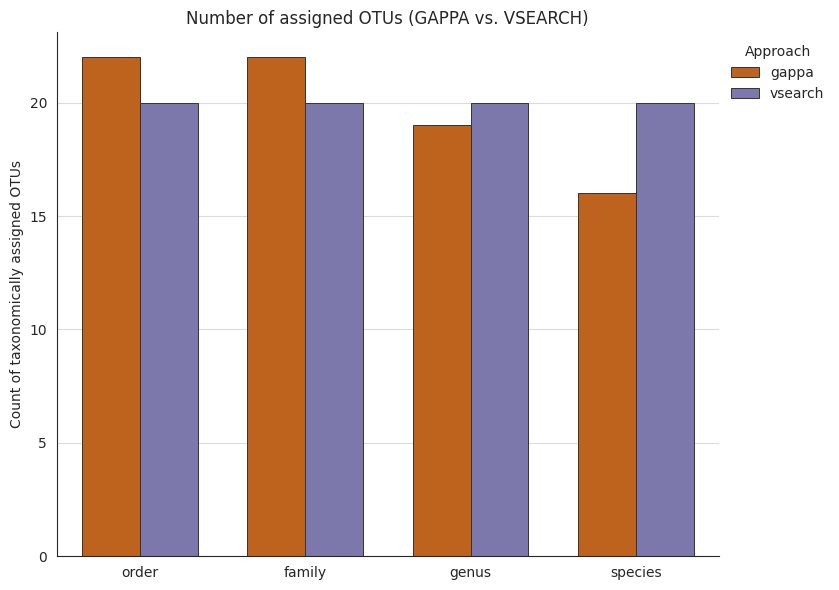

In [7]:
save_dir = os.path.join(results, 'main_figures')

count_tax_assigned_otus(melted_df = melted_df, 
                        save_dir = save_dir)